In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
%matplotlib inline

In [2]:
data= pd.read_csv(os.path.join('fashion-mnist_train.csv'))
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [3]:
#Segregate the data, normalise the feature vector, initialise a dictionary corresponding to the output array and map it. 
#Print a subset of the data like we did for the hand-written digit classification
def data_clean_Display(data): # 'data' is a pandas datafram                   
    # pass
    X = data.values[:,1:] ; y = data.values[:,0]
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X, y

In [4]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

[1 6 6 3 1 1]


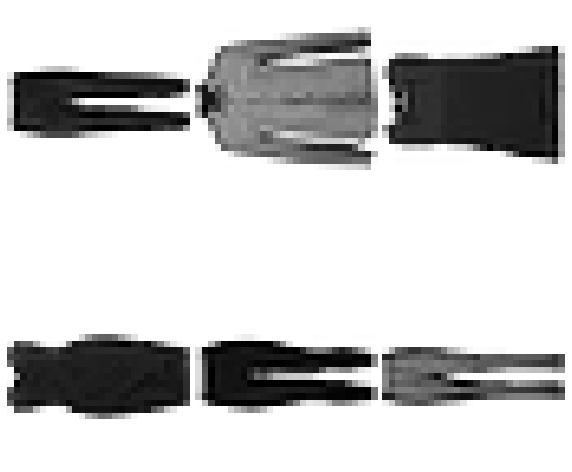

In [5]:
#Write code here to display sample set of data
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


X,y = data_clean_Display(train)
rand_indices = np.random.choice(y.shape[0],6, replace=False) # Randomly select 6 data points to display
sel = X[rand_indices, :]
print(y[rand_indices])

displayData(sel)

In [6]:
#Implement the sigmoid function
def sigmoid(z):
  g = 1.0 / (1.0 + np.exp(-z))
  return g

In [7]:
# Prediction based on trained model
# Use sigmoid function to calculate probability rounded off to either 0 or 1
#Prediction function for single hidden layer.
def predictSingleHiddenLayer(w1, w2, X): 
   # 'p' should be a vector of size equal to that of vector 'y'
    if X.ndim==1:
        X=X[None]
    
    m=X.shape[0]
    num_labels= w2.shape[0]
    
    p= np.zeros(m)
    
    a1= np.concatenate([np.ones((m,1)), X], axis=1) #Input layer
    
    a2= sigmoid(a1.dot(w1.T)) #Hidden Layer
    
    a2= np.concatenate([np.ones((a2.shape[0],1)), a2 ], axis=1) #Activation of 2nd layer
    
    a3= sigmoid(a2.dot(w2.T))
    
    p= np.argmax(a3, axis=1)
    return p 

In [8]:
#Prediction function for double hidden layer.
def predictDoubleHiddenLayer(w1, w2, w3, X): 
    # pass    # 'p' should be a vector of size equal to that of vector 'y'
    if X.ndim==1:
        X=X[None]
    
    m=X.shape[0]
    num_labels= w2.shape[0]
    
    p= np.zeros(m)
    
    a1= np.concatenate([np.ones((m,1)), X], axis=1) #Input layer
    
    a2= sigmoid(a1.dot(w1.T)) #Hidden Layer
    
    a2= np.concatenate([np.ones((a2.shape[0],1)), a2 ], axis=1) #Activation of 2nd layer
    
    a3= sigmoid(a2.dot(w2.T))

    a3 = np.concatenate([np.ones((a3.shape[0],1)), a3], axis = 1)  # Activation of 3rd layer

    a4 = sigmoid(a3.dot(w3.T))
     
    p= np.argmax(a4, axis=1)
    return p   

In [9]:
#implement the gradient of the sigmoid function
def sigmoidGradient(z):
    g = sigmoid(z)
    g = g*(1-g)
    return g

In [10]:
# Setup the parameters you will use for this exercise
input_layer_size  =  784
hidden_layer_size_One =  25  
hidden_layer_size_Two = 25  
num_labels =  10       #number of output labels

In [28]:
#randomly initialise weights.
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.zeros((L_out, 1 + L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init

    return W

In [29]:
initial_w1_1 = randInitializeWeights(input_layer_size, hidden_layer_size_One, epsilon_init=0.12)
initial_w2_1 = randInitializeWeights(hidden_layer_size_One, num_labels, epsilon_init=0.12)    #only when you're using the Second Hidden Layer

# Unroll parameters into a single array

initial_nn_params1 = np.concatenate([initial_w1_1.ravel(), initial_w2_1.ravel()], axis=0)

In [30]:
initial_w1_2 = randInitializeWeights(input_layer_size, hidden_layer_size_One, epsilon_init=0.12)
initial_w2_2 = randInitializeWeights(hidden_layer_size_One, hidden_layer_size_Two, epsilon_init=0.12)
initial_w3_2 = randInitializeWeights(hidden_layer_size_One, num_labels, epsilon_init=0.12)    #only when you're using the Second Hidden Layer

# Unroll parameters into a single array

initial_nn_params2 = np.concatenate([initial_w1_2.ravel(), initial_w2_2.ravel(), initial_w3_2.ravel()], axis=0)

In [48]:
def nnCostFunction1(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.1):
  
    w1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))
    
    w2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    w1_grad = np.zeros(w1.shape)
    w2_grad = np.zeros(w2.shape)
    # ================================================================================================
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(w1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(w2.T))
    
    y_matrix= y.reshape(-1)
    y_matrix= np.eye(num_labels)[y_matrix]
    
    temp1=w1
    temp2=w2
    reg_term= (lambda_/(2*m))*(np.sum(np.square(temp1[:,1:]))+np.sum(np.square(temp2[:,1:])))
    
    J= -(1/m)*np.sum((np.log(a3)*y_matrix)+np.log(1-a3)*(1-y_matrix))+reg_term

    # Backpropogation
    # delta_4 = a4-y_matrix
    delta_3 = a3-y_matrix
    delta_2 = delta_3.dot(w2)[:, 1:]*sigmoidGradient(a1.dot(w1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)

    # Adding regularization
    w1_grad = (1/m)*Delta1
    w2_grad = (1/m)*Delta2

    w1_grad[:, 1:] = w1_grad[:, 1:] + (lambda_/m)*w1[:, 1:]
    w2_grad[:, 1:] = w2_grad[:, 1:] + (lambda_/m)*w2[:, 1:]

    grad = np.concatenate([w1_grad.ravel(), w2_grad.ravel()])

    return J,grad

In [49]:
def nnCostFunction2(nn_params,
                   input_layer_size,
                   hidden_layer_size_One,
                   hidden_layer_size_Two,
                   num_labels,
                   X, y, lambda_=0.1):
  
    w1 = np.reshape(nn_params[:hidden_layer_size_One * (input_layer_size + 1)],
                        (hidden_layer_size_One, (input_layer_size + 1)))
    
    w2 = np.reshape(nn_params[(hidden_layer_size_One * (input_layer_size + 1)): hidden_layer_size_One * (input_layer_size + 1) + hidden_layer_size_Two * (hidden_layer_size_One+1)],
                        (hidden_layer_size_Two, (hidden_layer_size_One + 1)))
    
    w3 = np.reshape(nn_params[hidden_layer_size_One * (input_layer_size + 1) + hidden_layer_size_Two * (hidden_layer_size_One+1):],
                        (num_labels, (hidden_layer_size_Two + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    w1_grad = np.zeros(w1.shape)
    w2_grad = np.zeros(w2.shape)
    w3_grad = np.zeros(w3.shape)
    # ================================================================================================
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(w1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(w2.T))
    a3 = np.concatenate([np.ones((a3.shape[0],1)), a3], axis = 1)  # Activation of 3rd layer

    a4 = sigmoid(a3.dot(w3.T))
    
    y_matrix= y.reshape(-1)
    y_matrix= np.eye(num_labels)[y_matrix]
    
    temp1=w1
    temp2=w2
    temp3=w3
    reg_term= (lambda_/(2*m))*(np.sum(np.square(temp1[:,1:]))+np.sum(np.square(temp2[:,1:]))+np.sum(np.square(temp3[:,1:])))
    
    J= -(1/m)*np.sum((np.log(a4)*y_matrix)+np.log(1-a4)*(1-y_matrix))+reg_term

    # Backpropogation
    delta_4 = a4-y_matrix
    delta_3 = delta_4.dot(w3)[:, 1:]*sigmoidGradient(a2.dot(w2.T))
    delta_2 = delta_3.dot(w2)[:, 1:]*sigmoidGradient(a1.dot(w1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    Delta3 = delta_4.T.dot(a3)

    # Adding regularization
    w1_grad = (1/m)*Delta1
    w2_grad = (1/m)*Delta2
    w3_grad = (1/m)*Delta3

    w1_grad[:, 1:] = w1_grad[:, 1:] + (lambda_/m)*w1[:, 1:]
    w2_grad[:, 1:] = w2_grad[:, 1:] + (lambda_/m)*w2[:, 1:]
    w3_grad[:, 1:] = w3_grad[:, 1:] + (lambda_/m)*w3[:, 1:]

    grad = np.concatenate([w1_grad.ravel(), w2_grad.ravel(), w3_grad.ravel()])

    return J,grad

In [50]:
# Write code to pass the cost function to scipy's optimise.minimize
options = {'maxiter': 4000}

lambda_ = 0.1

costFunction1 = lambda p: nnCostFunction1(p, input_layer_size, 
                                        hidden_layer_size_One, 
                                        num_labels, X, y, lambda_)

res1 = optimize.minimize(costFunction1,
                        initial_nn_params1,
                        jac=True,
                        method='TNC',
                        options=options)

In [ ]:
# Write code to pass the cost function to scipy's optimise.minimize
options = {'maxiter': 4000}

lambda_ = 0.1

costFunction2 = lambda p: nnCostFunction2(p, input_layer_size, 
                                        hidden_layer_size_One,
                                        hidden_layer_size_Two, 
                                        num_labels, X, y, lambda_)

res2 = optimize.minimize(costFunction2,
                        initial_nn_params2,
                        jac=True,
                        method='TNC',
                        options=options)

In [52]:
res1

     fun: 0.062272036256021686
     jac: array([-1.80084884e-05, -1.51349919e-10, -2.30915152e-08, ...,
        1.87109045e-06,  3.88140315e-06,  3.84148294e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 4000
     nit: 213
  status: 3
 success: False
       x: array([-5.19176367e-01, -2.84994633e-04, -2.05700160e-02, ...,
        2.25557778e+00, -2.26945685e+00, -7.97021763e-02])

In [53]:
res2

     fun: 0.0296739714172009
     jac: array([ 3.10422850e-06,  1.30934663e-11, -1.01868464e-08, ...,
       -1.61030376e-07, -3.02433933e-07, -8.17717098e-07])
 message: 'Max. number of function evaluations reached'
    nfev: 4000
     nit: 243
  status: 3
 success: False
       x: array([ 7.84914738e-01,  4.15477607e-06,  2.05851075e-03, ...,
       -1.04946081e+00, -2.14397248e+00, -2.63904749e+00])

In [54]:
data_test= pd.read_csv(os.path.join('fashion-mnist_test.csv'))
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [55]:
nn_params1 = res1.x

hidden_layer_size = 25
w1 = np.reshape(nn_params1[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))
    
w2 = np.reshape(nn_params1[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))


In [56]:
nn_params2 = res2.x

w1 = np.reshape(nn_params2[:hidden_layer_size_One * (input_layer_size + 1)],
                    (hidden_layer_size_One, (input_layer_size + 1)))
    
w2 = np.reshape(nn_params2[(hidden_layer_size_One * (input_layer_size + 1)): hidden_layer_size_One * (input_layer_size + 1) + hidden_layer_size_Two * (hidden_layer_size_One+1)],
                    (hidden_layer_size_Two, (hidden_layer_size_One + 1)))
    
w3 = np.reshape(nn_params2[hidden_layer_size_One * (input_layer_size + 1) + hidden_layer_size_Two * (hidden_layer_size_One+1):],
                    (num_labels, (hidden_layer_size_Two + 1)))


In [ ]:
pred1 = predictSingleHiddenLayer(w1, w2, X)            # training_acc for single hidden layer
print(np.mean(pred1 == y) * 100)

In [ ]:
pred2 = predictDoubleHiddenLayer(w1, w2, w3, X)         # training_acc for double hidden layer
print(np.mean(pred2 == y) * 100)

In [59]:
# testing accuracy
X_test, y_test = data_clean_Display(test)

In [ ]:
pred1_test = predictSingleHiddenLayer(w1, w2, X_test) 
print(np.mean(pred1_test == y_test) * 100)

In [61]:
pred2_test = predictDoubleHiddenLayer(w1, w2, w3, X_test) 
print(np.mean(pred2_test == y_test) * 100)

86.66666666666667


nn pred: 16


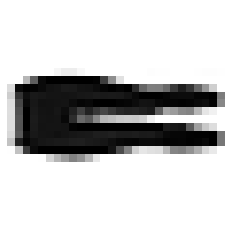

In [62]:
if rand_indices.size>0:
  i, rand_indices = rand_indices[0], rand_indices[1:]
  displayData(X[i, :], figsize=(4,4))
  pred = predictSingleHiddenLayer(w1, w2, X[i, :])
  print('nn pred: {}'.format(*pred1))

else:
  print('no more images to display')

nn pred: 1


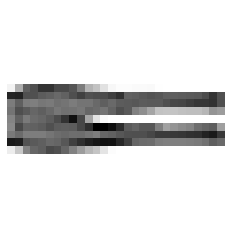

In [63]:
if rand_indices.size>0:
  i, rand_indices = rand_indices[0], rand_indices[1:]
  displayData(X[i, :], figsize=(4,4))
  pred = predictDoubleHiddenLayer(w1, w2, w3, X[i, :])
  print('nn pred: {}'.format(*pred))

else:
  print('no more images to display')